# Logistic Regression

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


## Step 1: Import the necessary Libraries
we will need to import libraries that allow for data analysis and data visualization to get acclimated to the dataset. We will be using pandas, numpy, matplotlib and seaborn to conduct this. Data Exploration libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings("ignore",'detected Windows; aliasing chunkize to chunkize_serial')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## Step 2: Read in the dataset.
We will use the pandas .read_csv() method to read in the dataset. Then we will use the. head() method to observe the first few rows of the data, to understand the information better. In our case, the feature(column) headers tell us pretty little. This is fine because we are merely trying to gain insight via classifying new data points by referencing it’s neighboring elements.

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv("C:\\VipinML\\Assignment 2\\Assignments_DonorsChoose_2018\\train_data.csv")
resource_data = pd.read_csv("C:\\VipinML\Assignment 2\\Assignments_DonorsChoose_2018\\resources.csv")
#Limit the data for testing purpose since processing takes few hours for full set..

project_data = project_data.head(2000)
resource_data = resource_data.head (2000)


In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (2000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]
#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,Mrs.,GA,2016-04-27 00:53:00,Grades PreK-2,Applied Learning,Early Development,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1


## 1.2 preprocessing of `project_subject_categories`

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))



In [7]:
teacher_cat = list(project_data['teacher_prefix'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in teacher_cat:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
    temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
    temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())


project_data.drop(['teacher_prefix'], axis=1, inplace=True)
project_data['teacher_prefix'] = sub_cat_list
    
from collections import Counter
my_counter = Counter()
for word in project_data['teacher_prefix'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_teacher_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 Text preprocessing

In [8]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [9]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay
473,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...


In [10]:
#### 1.4.2.3 Using Pretrained Models: TFIDF weighted W2V

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent = decontracted(project_data['essay'].values[500])
print(sent[1:200])
print("="*100)

s a teacher at a Title 1 school, many of my students receive free or reduced price lunch and have extremely limited resources.  Some face challenges daily that many adults never have to experience. M


In [13]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent[1:200])
print(sent[1:200])

s a teacher at a Title 1 school, many of my students receive free or reduced price lunch and have extremely limited resources.  Some face challenges daily that many adults never have to experience. M
s a teacher at a Title 1 school, many of my students receive free or reduced price lunch and have extremely limited resources.  Some face challenges daily that many adults never have to experience. M


In [14]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent[1:200])

s a teacher at a Title 1 school many of my students receive free or reduced price lunch and have extremely limited resources Some face challenges daily that many adults never have to experience My st


In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

### 1.4.3 Merging price with project_data

In [16]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
print (price_data[1:3])
project_data.head(1)

        id   price  quantity
1  p003483   81.28        40
2  p006068  557.98        16


,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,NaN,NaN


In [17]:
#Convert NaN value to mean of the column
project_data.fillna(project_data.mean(), inplace=True)
project_data.head(1)

,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
0,100660,p234804,cbc0e38f522143b86d372f8b43d4cff3,GA,2016-04-27 00:53:00,Grades PreK-2,Flexible Seating for Flexible Learning,I recently read an article about giving studen...,I teach at a low-income (Title 1) school. Ever...,We need a classroom rug that we can use as a c...,"Benjamin Franklin once said, \""Tell me and I f...",My students need flexible seating in the class...,2,1,AppliedLearning,EarlyDevelopment,EarlyDevelopment,I recently read an article about giving studen...,103.01,4.0


## Splitting data into Train and cross validation(or test): Stratified Sampling

In [18]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)




In [19]:
catogories_essay = list(project_data['essay'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_essay_list = []
for i in catogories_essay:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_essay_list.append(temp.strip())
    
project_data['clean_essay'] = cat_essay_list

from collections import Counter
my_counter = Counter()
for word in project_data['clean_essay'].values:
    my_counter.update(word.split())

cat_essay_dict = dict(my_counter)
sorted_cat_essay_dict = dict(sorted(cat_essay_dict.items(), key=lambda kv: kv[1]))



In [20]:
catogories_title = list(project_data['project_title'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
project_title_list = []
for i in catogories_title:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    project_title_list.append(temp.strip())

#project_data.drop('project_title', axis=1, inplace=True)
#project_data['project_title'] = project_title_list

from collections import Counter
my_counter = Counter()
for word in project_data['project_title'].values:
    my_counter.update(word.split())

project_title_dict = dict(my_counter)
sorted_project_title_dict = dict(sorted(project_title_dict.items(), key=lambda kv: kv[1]))

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
X_train_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_train_preprocessed_essays.append(sent.lower().strip())
   # print (X_train_preprocessed_essays)
    

100%|██████████| 1340/1340 [00:00<00:00, 1913.87it/s]


In [22]:
# Combining all the above stundents 
from tqdm import tqdm
X_test_preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    X_test_preprocessed_essays.append(sent.lower().strip())
   # print (X_test_preprocessed_essays)
    

100%|██████████| 660/660 [00:00<00:00, 1885.26it/s]


## Step 3: Standardize (normalize) the data scale to prep for Logistic regression.
Because the distance between pairs of points plays a critical part on the classification, it is necessary to normalize the data This will generate an array of values. 

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### Vectorization of clean_categories for X_train,X_test

In [23]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
X_train_categories_one_hot = vectorizer.transform(X_train['clean_categories'].values)
X_test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix X_train_categories_one_hot  after one hot encodig ",X_train_categories_one_hot.shape)
print("Shape of matrix X_test_categories_one_hot after one hot encodig ",X_test_categories_one_hot.shape)


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix X_train_categories_one_hot  after one hot encodig  (1340, 9)
Shape of matrix X_test_categories_one_hot after one hot encodig  (660, 9)


In [24]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
X_train_school_state_one_hot = vectorizer.transform(X_train['school_state'].values)
X_test_school_state_one_hot = vectorizer.transform(X_test['school_state'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix X_train_school_state_one_hot  after one hot encodig ",X_train_school_state_one_hot.shape)
print("Shape of matrix X_test_school_state_one_hot after one hot encodig ",X_test_school_state_one_hot.shape)


['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix X_train_school_state_one_hot  after one hot encodig  (1340, 9)
Shape of matrix X_test_school_state_one_hot after one hot encodig  (660, 9)


### Vectorization of clean_subcategories for X_train,X_test

In [25]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
X_train_sub_categories_one_hot = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)

print(vectorizer.get_feature_names())
print("Shape of matrix X_train_sub_categories_one_hot  after one hot encodig ",X_train_sub_categories_one_hot.shape)
print("Shape of matrix X_test_sub_categories_one_hot after oneX_test_sub_categories_one_hot  hot encodig ",X_test_sub_categories_one_hot.shape)


['Economics', 'ForeignLanguages', 'FinancialLiteracy', 'Extracurricular', 'CommunityService', 'ParentInvolvement', 'Civics_Government', 'Warmth', 'Care_Hunger', 'NutritionEducation', 'SocialSciences', 'CharacterEducation', 'History_Geography', 'PerformingArts', 'TeamSports', 'College_CareerPrep', 'Other', 'Music', 'ESL', 'EarlyDevelopment', 'Health_LifeScience', 'Gym_Fitness', 'VisualArts', 'EnvironmentalScience', 'AppliedSciences', 'Health_Wellness', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix X_train_sub_categories_one_hot  after one hot encodig  (1340, 30)
Shape of matrix X_test_sub_categories_one_hot after oneX_test_sub_categories_one_hot  hot encodig  (660, 30)


In [26]:
# you can do the similar thing with state, teacher_prefix and project_grade_category also

## TFIDF of preprocessed_essays for X_train,X_test

In [27]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train_preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
X_train_dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
X_train_tfidf_words = set(tfidf_model.get_feature_names())
print (len(X_train_tfidf_words))

10375


In [28]:
## X_train TFIDF of preprocessed_essays for X_test

In [29]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_test_preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
X_test_dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
X_test_tfidf_words = set(tfidf_model.get_feature_names())
print (len(X_test_tfidf_words))

7554


### 1.4.2 Vectorizing Text data

In [30]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('C:\\VipinML\\InputData\\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### Vectorization of preprocessed_essays for X_train,X_test

In [31]:
# average Word2Vec
# compute average word2vec for each review.
X_train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_avg_w2v_vectors.append(vector)

print(len(X_train_avg_w2v_vectors))
print(len(X_train_avg_w2v_vectors[0]))

100%|██████████| 1340/1340 [00:00<00:00, 3453.95it/s]


1340
300


In [32]:
# average Word2Vec
# compute average word2vec for each review.
X_test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_avg_w2v_vectors.append(vector)

print(len(X_test_avg_w2v_vectors))
print(len(X_test_avg_w2v_vectors[0]))

100%|██████████| 660/660 [00:00<00:00, 3275.57it/s]


660
300


In [33]:
## TFIDF-W2W Vecorization

In [34]:
# average Word2Vec
# compute average word2vec for each review.
X_train_tfidf_w2v_vectors_pessays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_train_tfidf_words):
           # print (word)
            if word == 'affluent':
                #print  (model[word])
                print (sentence.count(word))
                print (len(sentence.split()))
                print (X_train_dictionary[word])
                
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_train_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_pessays.append(vector)

print(len(X_train_tfidf_w2v_vectors_pessays))
print(len(X_train_tfidf_w2v_vectors_pessays[0]))

  4%|▎         | 48/1340 [00:00<00:02, 476.54it/s]

1
154
5.803275610483308


  8%|▊         | 101/1340 [00:00<00:02, 489.02it/s]

1
193
5.803275610483308


 11%|█▏        | 152/1340 [00:00<00:02, 494.07it/s]

1
139
5.803275610483308


 19%|█▉        | 254/1340 [00:00<00:02, 493.70it/s]

1
313
5.803275610483308


 37%|███▋      | 490/1340 [00:01<00:01, 465.31it/s]

1
135
5.803275610483308


 68%|██████▊   | 905/1340 [00:02<00:01, 402.84it/s]

1
140
5.803275610483308


 77%|███████▋  | 1035/1340 [00:02<00:00, 416.33it/s]

1
128
5.803275610483308


 84%|████████▍ | 1128/1340 [00:02<00:00, 434.07it/s]

1
111
5.803275610483308
1
115
5.803275610483308


 91%|█████████ | 1219/1340 [00:02<00:00, 425.33it/s]

1
183
5.803275610483308


100%|██████████| 1340/1340 [00:03<00:00, 437.93it/s]


1340
300


In [35]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors_pessays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test_preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_test_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_test_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_pessays.append(vector)

print(len(X_test_tfidf_w2v_vectors_pessays))
print(len(X_test_tfidf_w2v_vectors_pessays[0]))

100%|██████████| 660/660 [00:01<00:00, 452.02it/s]


660
300


In [36]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors_ptitle = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_test_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_test_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v_vectors_ptitle.append(vector)

print(len(X_test_tfidf_w2v_vectors_ptitle))
print(len(X_test_tfidf_w2v_vectors_ptitle[0]))

100%|██████████| 660/660 [00:00<00:00, 82740.25it/s]


660
300


In [37]:
# average Word2Vec
# compute average word2vec for each review.

X_train_tfidf_w2v_vectors_ptitle = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in X_train_tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = X_train_dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v_vectors_ptitle.append(vector)

print(len(X_train_tfidf_w2v_vectors_ptitle))
print(len(X_train_tfidf_w2v_vectors_ptitle[0]))

100%|██████████| 1340/1340 [00:00<00:00, 78939.96it/s]


1340
300


### Vectorization of teacher_prefix  for X_train,X_test, X_cv

In [38]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), vocabulary=list(sorted_teacher_dict.keys()),max_features=5000, lowercase=False, binary=True)
X_train_teacher_prefix_data = X_train['teacher_prefix']

X_train_teacher_prefix_data.fillna("Mrs.", inplace = True) 

teacher_prefix_notnull = X_train_teacher_prefix_data[pd.notnull(X_train_teacher_prefix_data)]

vectorizer.fit(teacher_prefix_notnull.values)

#print(vectorizer.get_feature_names())

print(teacher_prefix_notnull.values)

X_train_teacher_prefix_one_hot = vectorizer.transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_train_teacher_prefix_one_hot.shape)


['Literacy Mathematics' 'Literacy' 'Literacy' ... 'EarlyDevelopment'
 'Literature_Writing VisualArts' 'Health_Wellness']
Shape of matrix after one hot encodig  (1340, 30)


In [39]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,vocabulary=list(sorted_teacher_dict.keys()), lowercase=False, binary=True)
X_test_teacher_prefix_data = X_test['teacher_prefix']
X_test_teacher_prefix_data.fillna("Mrs.", inplace = True) 
teacher_prefix_notnull = X_test_teacher_prefix_data[pd.notnull(X_test_teacher_prefix_data)]
vectorizer.fit(teacher_prefix_notnull.values)
X_test_teacher_prefix_one_hot = vectorizer1.transform(teacher_prefix_notnull.values)
print("Shape of matrix after one hot encodig ",X_test_teacher_prefix_one_hot.shape)


Shape of matrix after one hot encodig  (660, 30)


### Vectorization of price for X_train,X_test

In [40]:
X_train.head(1)
X_test.head(1)


,Unnamed: 0,id,teacher_id,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,teacher_prefix,essay,price,quantity
1727,128296,p250439,3ecb608a8131b5ad227124a8a076d64e,CA,2017-02-25 17:14:47,Grades 6-8,Flexible Seating For Focused Students,"My students are highly motivated, creative, an...",Walk into a typical classroom and see students...,NaN,NaN,"My students need wobble chairs, wobble cushion...",14,Health_Sports,Health_Wellness,Health_Wellness,"My students are highly motivated, creative, an...",103.01,4.0


In [41]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

#normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


In [42]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


In [43]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1340, 1) (1340,)
(660, 1) (660,)


## Bag of words of preprocessed_essays for X_train,X_test

In [44]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4),  max_features=5000,vocabulary=list(sorted_cat_essay_dict.keys()))
X_train_text_bow = vectorizer.fit_transform(X_train_preprocessed_essays)
X_test_text_bow = vectorizer.transform(X_test_preprocessed_essays)

print("Shape of matrix X_train_text_bow after one hot encodig ",X_train_text_bow.shape)
print("Shape of matrix X_test_text_bow after one hot encodig ",X_test_text_bow.shape)


Shape of matrix X_train_text_bow after one hot encodig  (1340, 18680)
Shape of matrix X_test_text_bow after one hot encodig  (660, 18680)


## Bag of words of project_title for X_train,X_test

In [45]:
# PROJECT_TITLE BOW
# We are considering only the words which appeared in at least 10 documents(rows or projects). 
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000,vocabulary=list(sorted_project_title_dict.keys()))
X_train_project_title_bow = vectorizer.fit_transform(X_train['project_title'])
X_test_project_title_bow = vectorizer.transform(X_test['project_title'])

print("Shape of matrix X_train_project_title_bow after one hot encodig ",X_train_project_title_bow .shape)
print("Shape of matrix X_test_project_title_bow after one hot encodig ",X_test_project_title_bow .shape)


Shape of matrix X_train_project_title_bow after one hot encodig  (1340, 3525)
Shape of matrix X_test_project_title_bow after one hot encodig  (660, 3525)


## TFIDF of preprocessed_essays for X_train,X_test

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_text_tfidf = vectorizer.fit_transform(X_train_preprocessed_essays)
X_test_text_tfidf = vectorizer.transform(X_test_preprocessed_essays)

print("Shape of matrix X_train_text_tfidf after one hot encodig ",X_train_text_tfidf.shape)
print("Shape of matrix X_test_text_tfidf after one hot encodig ",X_test_text_tfidf.shape)


Shape of matrix X_train_text_tfidf after one hot encodig  (1340, 10375)
Shape of matrix X_test_text_tfidf after one hot encodig  (660, 10375)


## TFIDF of Project Title for X_train,X_test

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
X_train_project_title_tfidf = vectorizer.fit_transform((X_train['project_title']))
X_test_project_title_tfidf = vectorizer.transform((X_test['project_title']))

print("Shape of matrix  X_train_project_title_tfidf after one hot encodig ",X_train_project_title_tfidf.shape)
print("Shape of matrix  X_test_project_title_tfidf after one hot encodig ",X_test_project_title_tfidf.shape)


Shape of matrix  X_train_project_title_tfidf after one hot encodig  (1340, 115)
Shape of matrix  X_test_project_title_tfidf after one hot encodig  (660, 115)


### TFIDF AVG W2V for Project Title for X_train,X_test

In [48]:
# average Word2Vec
# compute average word2vec for each review.
X_train_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_project_title_avg_w2v_vectors.append(vector)

print(len(X_train_project_title_avg_w2v_vectors))
print(len(X_train_project_title_avg_w2v_vectors[0]))

100%|██████████| 1340/1340 [00:00<00:00, 133882.02it/s]


1340
300


In [49]:
# average Word2Vec
# compute average word2vec for each review.
X_test_project_title_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_project_title_avg_w2v_vectors.append(vector)

print(len(X_test_project_title_avg_w2v_vectors))
print(len(X_test_project_title_avg_w2v_vectors[0]))

100%|██████████| 660/660 [00:00<00:00, 109672.38it/s]


660
300


In [50]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack


X_tr = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot)).tocsr()
X_te = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot)).tocsr()

#print (X_train_price_norm)
X_tr_bow = hstack((X_train_price_norm,X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_text_bow,X_train_project_title_bow)).tocsr()
X_te_bow = hstack((X_test_price_norm,X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_text_bow,X_test_project_title_bow)).tocsr()

X_tr_tfidf = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_tfidf,X_train_text_tfidf)).tocsr()
X_te_tfidf = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_tfidf,X_test_text_tfidf)).tocsr()

X_tr_tfidf_w2v = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_avg_w2v_vectors)).tocsr()
X_te_tfidf_w2v = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_avg_w2v_vectors)).tocsr()


X_tr_avg_w2v = hstack((X_train_sub_categories_one_hot,X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_project_title_avg_w2v_vectors)).tocsr()
X_te_avg_w2v = hstack((X_test_sub_categories_one_hot,X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_project_title_avg_w2v_vectors)).tocsr()

#set 5

X_te_set5 =hstack((X_test_school_state_one_hot,X_test_categories_one_hot,X_test_sub_categories_one_hot,\
                  X_test_teacher_prefix_one_hot,X_test_quantity_norm,X_test_price_norm,\
                  X_test_teacher_number_of_previously_posted_projects_norm,X_test_price_norm))

X_tr_set5 =hstack((X_train_school_state_one_hot,X_train_categories_one_hot, X_train_sub_categories_one_hot,\
                  X_train_teacher_prefix_one_hot,X_train_quantity_norm,X_train_price_norm,\
                  X_train_teacher_number_of_previously_posted_projects_norm,X_train_price_norm))

X_te_tfidf_avg_w2v = hstack((X_test_school_state_one_hot,X_test_categories_one_hot,X_test_sub_categories_one_hot,\
                  X_test_tfidf_w2v_vectors_pessays,X_test_tfidf_w2v_vectors_ptitle))

X_tr_tfidf_avg_w2v = hstack((X_train_school_state_one_hot,X_train_categories_one_hot, X_train_sub_categories_one_hot,\
                  X_train_tfidf_w2v_vectors_pessays,X_train_tfidf_w2v_vectors_ptitle))

#print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

print("="*100)

print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

print(X_tr_set5.shape,y_train.shape )
print(X_te_set5.shape,y_test.shape )
print("="*100)


(1340, 61) (1340,)
(660, 61) (660,)
(1340, 10551) (1340,)
(660, 10551) (660,)
(1340, 82) (1340,)
(660, 82) (660,)


# Assignment 5: Logistic Regression

<ol>
    <li><strong>[Task-1] Logistic Regression(either SGDClassifier with log loss, or LogisticRegression) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (`BOW with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (`TFIDF with bi-grams` with `min_df=10` and `max_features=5000`)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_essay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2] Apply Logistic Regression on the below feature set <font color='red'> Set 5 </font> by finding the best hyper parameter as suggested in step 2 and step 3.</strong>
    <li> Consider these set of features <font color='red'> Set 5 :</font>
            <ul>
                <li><strong>school_state</strong> : categorical data</li>
                <li><strong>clean_categories</strong> : categorical data</li>
                <li><strong>clean_subcategories</strong> : categorical data</li>
                <li><strong>project_grade_category</strong> :categorical data</li>
                <li><strong>teacher_prefix</strong> : categorical data</li>
                <li><strong>quantity</strong> : numerical data</li>
                <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
                <li><strong>price</strong> : numerical data</li>
                <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
                <li><strong>number of words in the title</strong> : numerical data</li>
                <li><strong>number of words in the combine essays</strong> : numerical data</li>
            </ul>
        And apply the Logistic regression on these features by finding the best hyper paramter as suggested in step 2 and step 3 <br>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h1>2. Logistic Regression </h1>

<h2>2.4 Appling Logistic Regression on different kind of featurization as mentioned in the instructions</h2>

<br>Apply Logistic Regression on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [51]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [52]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [53]:
def logistic_regression_validation(X_train,y_train,X_test,y_test):
    from sklearn import metrics
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    """
    y_true : array, shape = [n_samples] or [n_samples, n_classes]
    True binary labels or binary label indicators.

    y_score : array, shape = [n_samples] or [n_samples, n_classes]
    Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
    decisions (as returned by “decision_function” on some classifiers). 
    For binary y_true, y_score is supposed to be the score of the class with greater label.

    """
    # Create regularization penalty space
    penalty = ['l1', 'l2']

    # Create regularization hyperparameter space
    C = np.logspace(0.00001, 40, 10)
    print (C)
    
    print ("*")

    # Create hyperparameter options
    tuned_parameters = dict(C=C, penalty=penalty)
    
    #tuned_parameters = [{'C': [19**-6, 10**-5,10**-4, 10**-2,10**0, 10,10**2, 10**4]}]
    
   # print ([{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}])
    
    #Using GridSearchCV
    model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)

    model.fit(X_train, y_train)
    
    print("model.best_estimator_ = %s" % model.best_estimator_)
    print("model.score = %s" % model.score(X_test, y_test))

    y_train_pred = model.predict(X_train)    
    y_test_pred = model.predict(X_test)

   
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
    # calculate accuracy of class predictions
    from sklearn import metrics
    print ("Accuracy Score = %s" % metrics.accuracy_score(y_test, y_test_pred))
    print ("=====================================================")        
    print("Train confusion matrix")
    print(metrics.confusion_matrix(y_train, y_train_pred))
    print("Test confusion matrix")
    print(metrics.confusion_matrix(y_test, y_test_pred))



In [54]:
def logistic_regression_for_Best_Tuned_Parameter(X_train,y_train,X_test,y_test, TunedParameter):
    from sklearn import metrics
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score

    model = LogisticRegression(C=TunedParameter)

    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)    
    y_test_pred = model.predict(X_test)

   
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # calculate accuracy of class predictions
    from sklearn import metrics
    print ("Accuracy Score = %s" % metrics.accuracy_score(y_test, y_test_pred))
    print ("=====================================================")        
    print("Train confusion matrix")
    print(metrics.confusion_matrix(y_train, y_train_pred))
    print("Test confusion matrix")
    print(metrics.confusion_matrix(y_test, y_test_pred))


### Split the normalized data into training and test sets
Logic below is simialr as covred in kanalysis_cross_validation(X,y), but here logic is for to  calculate confusion matrix, acuarcy ration for best K as we already foound best K after trying best accuracy for multiple K values.
We can apply  K -fold CV to either the hyperparameter tuning, performance reporting, or both. The advantage of this approach is that the performance is less sensitive to unfortunate splits of data. In addition, it utilize data better since each example can be used for both training and validation/testing.

Let's use  K -Fold CV to select the hyperparamter n_neighbors of the KNeighborsClassifier:

### How to speculate the performance of the model using ROC Curve?
#### An excellent model has AUC near to the 1 which means it has good measure of separability. A poor model has AUC near to the 0 which means it has worst measure of separability. In fact it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means model has no class separation capacity whatsoever

### Split the normalized data into training and test sets
This step is required to prepare us for the fitting (i.e. training) the #model later. The “X” variable is a collection of all the features. The “y” variable is the target label which specifies the #classification of 1 or 0 based. Our goal will be to identify which category the new data point should fall into. Evaluate the predictions. Evaluate the Model by reviewing the classification report or confusion matrix. By reviewing these tables, we are able to evaluate how accurate our model is with new values.
Pleazse refer this website also. very well covered , how to draw confusion matrix or calculate accuracy ration. https://medium.com/@kbrook10/day-11-machine-learning-using-knn-k-nearest-neighbors-with-scikit-learn-350c3a1402e6

In [55]:
def LogicRegression_Tuned_Param_Analysis(X_train,y_train,X_test,y_test):
    from sklearn import model_selection
    from mlxtend.plotting import plot_decision_regions
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import roc_auc_score
    # Import classification report and confusion matrix to evaluate predictions
    from sklearn.metrics import classification_report, confusion_matrix

    train_auc = []
    test_auc = []
    Tunedparams = [19**-6, 10**-5,10**-4, 10**-2,10**0, 10,10**2, 10**3, 10**4]
    for TunedParameter in Tunedparams:
        model = LogisticRegression(C=TunedParameter)

        # fitting the model on crossvalidation train
        model.fit(X_train, y_train)

        # predict the response on the crossvalidation train
        y_train_pred = model.predict(X_train)  # predicting the value using cross validation data. 
        
        # predict the response on the crossvalidation test
        y_test_pred = model.predict(X_test)  # predicting the value using cross validation data. 
        

        # evaluate CV accuracy
        acc = accuracy_score(y_test, y_test_pred, normalize=True) * float(100)  # I get the accuracy score. 
        print('\n Test Accuracy for Tuned Parameter = %s is %s' % (TunedParameter, acc))
        print("=========================================")
        
        # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
        # not the predicted outputs        
        train_auc.append(roc_auc_score(y_train,y_train_pred))
        test_auc.append(roc_auc_score(y_test, y_test_pred))
        
    
    plt.plot(Tunedparams, train_auc, label='Train AUC')
    plt.plot(Tunedparams, test_auc, label='Test AUC')

    plt.scatter(Tunedparams, train_auc, label='Train AUC points')
    plt.scatter(Tunedparams, test_auc, label='Test AUC points')

    plt.legend()
    plt.xlabel("Tunedparams: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()
       

### 2.4.0 Applying Logistic Regression  Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

###  Logistic Regression feature selection

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.9189189189189189


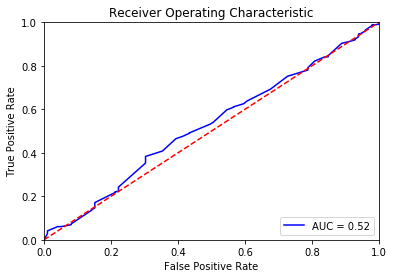

Accuracy Score = 0.85
Train confusion matrix
[[   0  202]
 [   0 1138]]
Test confusion matrix
[[  0  99]
 [  0 561]]


In [56]:
logistic_regression_validation (X_tr,y_train,X_te,y_test)

### 2.4.1 Applying Logistic Regression on BOW - Set 1: categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.8819444444444444


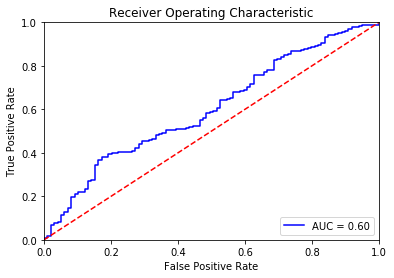

Accuracy Score = 0.793939393939394
Train confusion matrix
[[ 164   38]
 [   0 1138]]
Test confusion matrix
[[ 16  83]
 [ 53 508]]


In [57]:
logistic_regression_validation (X_tr_bow,y_train,X_te_bow,y_test)

### 2.4.2 Applying Logistic Regression  on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.9189189189189189


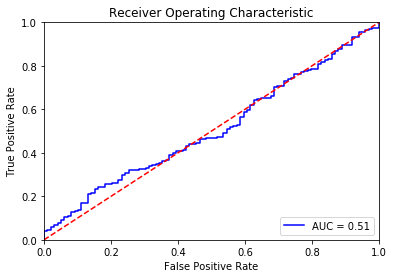

Accuracy Score = 0.85
Train confusion matrix
[[   1  201]
 [   0 1138]]
Test confusion matrix
[[  0  99]
 [  0 561]]


In [58]:
logistic_regression_validation(X_tr_tfidf,y_train,X_te_tfidf,y_test)

2.4.2 Applying Logistic Regression on TFIDF Avg W2V <font color='red'> SET 2</font>

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.9178981937602627


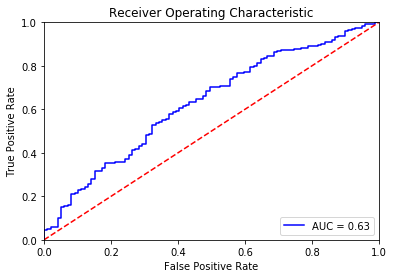

Accuracy Score = 0.8484848484848485
Train confusion matrix
[[  12  190]
 [   1 1137]]
Test confusion matrix
[[  1  98]
 [  2 559]]


In [59]:
logistic_regression_validation(X_tr_tfidf_avg_w2v,y_train,X_te_tfidf_avg_w2v,y_test)

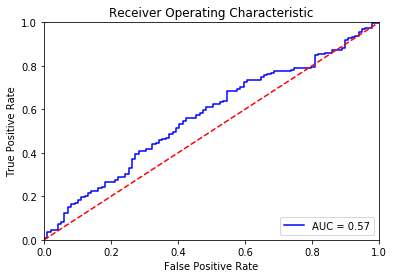

Accuracy Score = 0.85
Train confusion matrix
[[  48  154]
 [   0 1138]]
Test confusion matrix
[[  1  98]
 [  1 560]]


In [60]:
TunedParameter = 2
logistic_regression_for_Best_Tuned_Parameter(X_tr_tfidf,y_train,X_te_tfidf,y_test,TunedParameter)

### 2.4.3 Applying Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.918785890073831


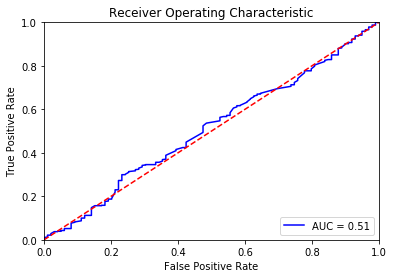

Accuracy Score = 0.85
Train confusion matrix
[[   0  202]
 [   0 1138]]
Test confusion matrix
[[  1  98]
 [  1 560]]


In [61]:
logistic_regression_validation(X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test)

### 2.4.4 Applying Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.918785890073831


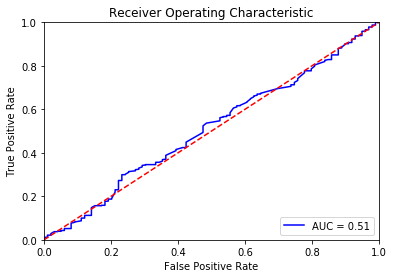

Accuracy Score = 0.85
Train confusion matrix
[[   0  202]
 [   0 1138]]
Test confusion matrix
[[  1  98]
 [  1 560]]


In [62]:
logistic_regression_validation(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test)

### 2.4.2 Applying Logistic Regression  on TFIDF Set 5: categorical, numerical features <font color='red'> SET 5</font>

[1.00002303e+00 2.78261635e+04 7.74277549e+08 2.15446776e+13
 5.99491919e+17 1.66811761e+22 4.64162446e+26 1.29155627e+31
 3.59382286e+35 1.00000000e+40]
*
model.best_estimator_ = LogisticRegression(C=1.0000230261160268, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.score = 0.9189189189189189


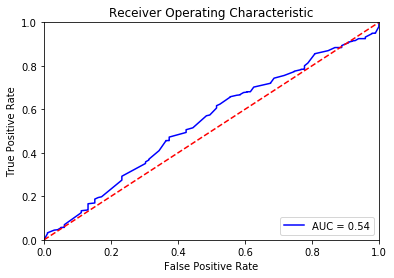

Accuracy Score = 0.85
Train confusion matrix
[[   0  202]
 [   0 1138]]
Test confusion matrix
[[  0  99]
 [  0 561]]


In [63]:
logistic_regression_validation(X_tr_set5,y_train,X_te_set5,y_test)

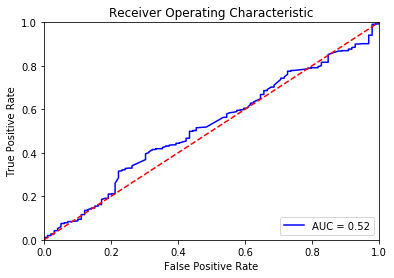

Accuracy Score = 0.8454545454545455
Train confusion matrix
[[  12  190]
 [   1 1137]]
Test confusion matrix
[[  0  99]
 [  3 558]]


In [64]:
TunedParameter =01.1
logistic_regression_for_Best_Tuned_Parameter(X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test, TunedParameter)

## 2.5  Feature selection for Best Tuned Parameter /font>

## 2.5.1 <font color='red'> Tuned Param-Analysis  <font color='blue'> categorical, numerical features + project_title(BOW) + preprocessed_essay (BOW),<font color='red'> SET 1</font>


 Test Accuracy for Tuned Parameter = 2.1255845968746978e-08 is 85.0

 Test Accuracy for Tuned Parameter = 1e-05 is 85.0

 Test Accuracy for Tuned Parameter = 0.0001 is 85.0

 Test Accuracy for Tuned Parameter = 0.01 is 84.84848484848484

 Test Accuracy for Tuned Parameter = 1 is 79.39393939393939

 Test Accuracy for Tuned Parameter = 10 is 76.51515151515152

 Test Accuracy for Tuned Parameter = 100 is 75.30303030303031

 Test Accuracy for Tuned Parameter = 1000 is 75.30303030303031

 Test Accuracy for Tuned Parameter = 10000 is 75.30303030303031


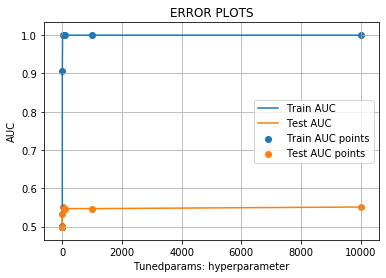

In [65]:
LogicRegression_Tuned_Param_Analysis(X_tr_bow,y_train,X_te_bow,y_test)

### 2.5.2 <font color='red'> Tuned Param -Analysis   <font color='blue'>  on TFIDF Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_essay (TFIDF),<font color='red'> SET 2</font>


 Test Accuracy for Tuned Parameter = 2.1255845968746978e-08 is 85.0

 Test Accuracy for Tuned Parameter = 1e-05 is 85.0

 Test Accuracy for Tuned Parameter = 0.0001 is 85.0

 Test Accuracy for Tuned Parameter = 0.01 is 85.0

 Test Accuracy for Tuned Parameter = 1 is 84.84848484848484

 Test Accuracy for Tuned Parameter = 10 is 83.48484848484848

 Test Accuracy for Tuned Parameter = 100 is 81.06060606060606

 Test Accuracy for Tuned Parameter = 1000 is 80.45454545454545

 Test Accuracy for Tuned Parameter = 10000 is 80.15151515151516


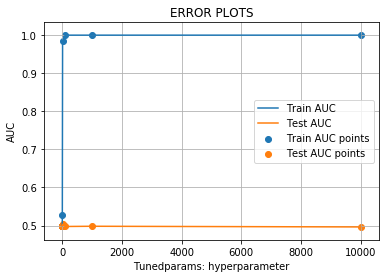

In [66]:
LogicRegression_Tuned_Param_Analysis(X_tr_tfidf,y_train,X_te_tfidf,y_test)

### 2.5.3 <font color='red'> Tuned Parameter-Analysis     <font color='blue'>  on AVG W2V - categorical, numerical features + project_title(AVG W2V )+ preprocessed_essay (AVG W2V ),<font color='red'> SET 3</font>


 Test Accuracy for Tuned Parameter = 2.1255845968746978e-08 is 85.0

 Test Accuracy for Tuned Parameter = 1e-05 is 85.0

 Test Accuracy for Tuned Parameter = 0.0001 is 85.0

 Test Accuracy for Tuned Parameter = 0.01 is 85.0

 Test Accuracy for Tuned Parameter = 1 is 84.54545454545455

 Test Accuracy for Tuned Parameter = 10 is 83.63636363636363

 Test Accuracy for Tuned Parameter = 100 is 83.63636363636363

 Test Accuracy for Tuned Parameter = 1000 is 83.93939393939394

 Test Accuracy for Tuned Parameter = 10000 is 83.63636363636363


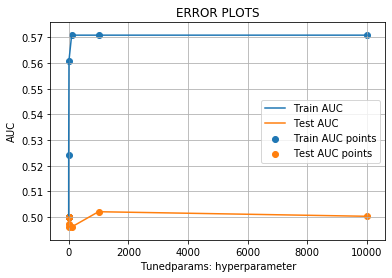

In [67]:
LogicRegression_Tuned_Param_Analysis(X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test)

### Tuned Param Analysis on TFIDF Set 5: categorical, numerical features + SET 5

### Logic Regression Analysis on Best Tuned Parameter


 Test Accuracy for Tuned Parameter = 2.1255845968746978e-08 is 85.0

 Test Accuracy for Tuned Parameter = 1e-05 is 85.0

 Test Accuracy for Tuned Parameter = 0.0001 is 85.0

 Test Accuracy for Tuned Parameter = 0.01 is 85.0

 Test Accuracy for Tuned Parameter = 1 is 85.0

 Test Accuracy for Tuned Parameter = 10 is 85.0

 Test Accuracy for Tuned Parameter = 100 is 85.0

 Test Accuracy for Tuned Parameter = 1000 is 85.0

 Test Accuracy for Tuned Parameter = 10000 is 85.0


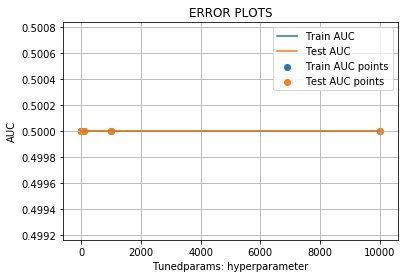

In [68]:
LogicRegression_Tuned_Param_Analysis(X_tr_set5,y_train,X_te_set5,y_test)


 Test Accuracy for Tuned Parameter = 2.1255845968746978e-08 is 85.0

 Test Accuracy for Tuned Parameter = 1e-05 is 85.0

 Test Accuracy for Tuned Parameter = 0.0001 is 85.0

 Test Accuracy for Tuned Parameter = 0.01 is 85.0

 Test Accuracy for Tuned Parameter = 1 is 84.54545454545455

 Test Accuracy for Tuned Parameter = 10 is 83.63636363636363

 Test Accuracy for Tuned Parameter = 100 is 83.63636363636363

 Test Accuracy for Tuned Parameter = 1000 is 83.93939393939394

 Test Accuracy for Tuned Parameter = 10000 is 83.63636363636363


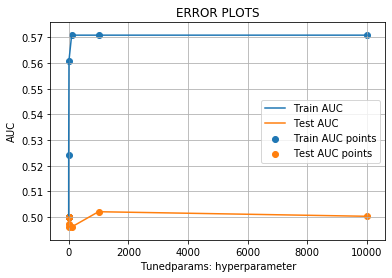

In [73]:
LogicRegression_Tuned_Param_Analysis(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test)

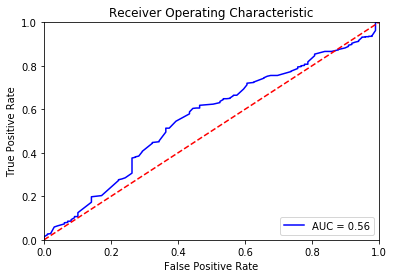

Accuracy Score = 0.85
Train confusion matrix
[[   0  202]
 [   0 1138]]
Test confusion matrix
[[  0  99]
 [  0 561]]


In [69]:
TunedParameter = 13.09
logistic_regression_for_Best_Tuned_Parameter(X_tr_set5,y_train,X_te_set5,y_test,TunedParameter)

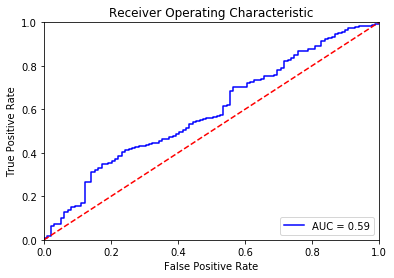

Accuracy Score = 0.7651515151515151
Train confusion matrix
[[ 202    0]
 [   0 1138]]
Test confusion matrix
[[ 24  75]
 [ 80 481]]


In [70]:
TunedParameter =10.01
logistic_regression_for_Best_Tuned_Parameter(X_tr_bow,y_train,X_te_bow,y_test, TunedParameter)

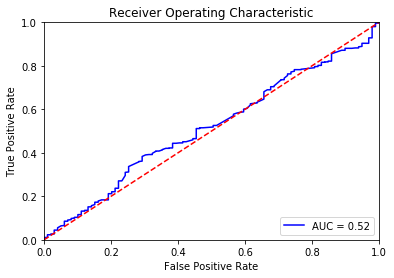

Accuracy Score = 0.8454545454545455
Train confusion matrix
[[  18  184]
 [   2 1136]]
Test confusion matrix
[[  1  98]
 [  4 557]]


In [71]:
TunedParameter = 2.0
logistic_regression_for_Best_Tuned_Parameter(X_tr_avg_w2v,y_train,X_te_avg_w2v,y_test, TunedParameter)

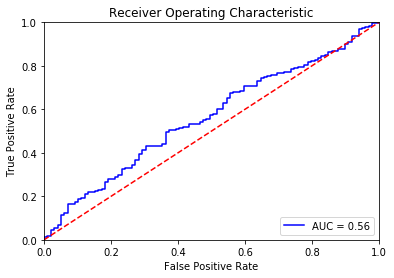

Accuracy Score = 0.8484848484848485
Train confusion matrix
[[  12  190]
 [   0 1138]]
Test confusion matrix
[[  0  99]
 [  1 560]]


In [72]:
TunedParameter = 1.02
logistic_regression_for_Best_Tuned_Parameter(X_tr_tfidf,y_train,X_te_tfidf,y_test,TunedParameter)

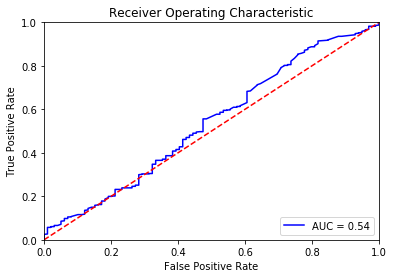

Accuracy Score = 0.85
Train confusion matrix
[[   0  202]
 [   0 1138]]
Test confusion matrix
[[  0  99]
 [  0 561]]


In [79]:
TunedParameter = 0.01
logistic_regression_for_Best_Tuned_Parameter(X_tr_tfidf_w2v,y_train,X_te_tfidf_w2v,y_test,TunedParameter)

<h1>3. Conclusions</h1>

Logistic Regression is a stastical method for analyzing a dataset in which there are one or more independent variables that determine the outcome. 

## Summary of above program as below:
### Step 1: Import the necessary Libraries
we will need to import libraries that allow for data analysis and data visualization to get acclimated to the dataset. We will be using pandas, numpy, matplotlib and seaborn to conduct this. Data Exploration libraries

### Step 2: Read in the dataset.
We will use the pandas .read_csv() method to read in the dataset. Then we will use the. head() method to observe the first few rows of the data, to understand the information better. In our case, the feature(column) headers tell us pretty little. This is fine because we are merely trying to gain insight via classifying new data points by referencing it’s neighboring elements.

### Step 3: Standardize (normalize) the data scale to prep for Logistic regression.
Because the distance between pairs of points plays a critical part on the classification, it is necessary to normalize the data This will generate an array of values. 

### Step 4: Split the normalized data into training and test sets.
This step is required to prepare us for the fitting (i.e. training) the model later. The “X” variable is a collection of all the features. The “y” variable is the target label which specifies the classification of 1 or 0 based. Our goal will be to identify which category the new data point should fall into.


### Step 5: Create and Train the Model.
Here we create a Logistic Regression Object and use the .fit() method to train the model. Upon completion of the model we should receive confirmation that the training has been complete

Please see functions as covered below, used in above program: def logistic_regression_validation(X,y): def 

### Step 6: Make Predictions.
Here we review where our model was accurate and where it misclassified elements.

Please see functions as covered below, used in above program: def logistic_regression_validation(X,y):

### Step 7: Evaluate the predictions.

Evaluate the Model by reviewing the classification report or confusion matrix. By reviewing these tables, we are able to evaluate how accurate our model is with new values.

def logistic_regression_validation(X,y):

### Setp 8:Classification Report :
This tells us our model was around 84% accurate… Print out classification report and confusion matrix

I have covered various set to show confusion matrix.

Please see section 2. covered various data sets and created confusion matrix.

### Step 9: Evaluate alternative Tuned Parameter for better predictions.
To simplify the process of evaluating multiple cases of Alpha values, we create a function to derive the error using the average where our predictions were not equal to the test values.

Please see section 2. covered various data sets and created error accuracy reports.

### Step 10: Adjust Tuned Parameter value per error rate evaluations 
This is just fine tuning our model to increase accuracy. We will need to retrain our model with the new Alpha.
Please see section 3 in above program. we have created confusion matrix for optimal Alpha value for various data sets. As we can see for optimal Alpha, Accuracy is much higher - so prediction is much better.

